In [46]:
import os
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from robustness import NETWORKS_DIR
from robustness.auxiliary import (
    read_data_file,
    get_base_network_name,
    getLinearReg, 
    powerlaw, 
)
%matplotlib inline

In [14]:
net_type = 'DT'
param = 'param'
seed = 5997

attacks = ['Btw_cutoff2']
sizes = [4096]

dir_name = NETWORKS_DIR / net_type
for attack in attacks:
    print(attack)
    for size in sizes:
        base_net_name, base_net_name_size = get_base_network_name(
            net_type, size, param
        )
        base_net_dir = dir_name / base_net_name / base_net_name_size
        network = f'{base_net_name_size}_{seed:05d}'
        attack_dir_name = base_net_dir / network / attack
        comp_data_file = 'comp_data'
        print(attack_dir_name)
        #aux = read_data_file(
        #    str(attack_dir_name), comp_data_file, 
        #    reader='pandas', sep=' ', header=None
        #).values
        
        aux = read_data_file(
            str(attack_dir_name), comp_data_file, 
            reader='numpy'
        )
        
        print(aux.shape)

Btw_cutoff2
/media/nahuel/E/E/dismantlingScaling/networks/DT/DT_param/DT_param_N4096/DT_param_N4096_05997/Btw_cutoff2
(4096, 6)


In [ ]:
ecounts = defaultdict(list)

In [58]:
from collections import defaultdict
from robustness.auxiliary import read_data_file
net_type = 'DT'
param = 'param'
seeds = range(100)
dir_name = NETWORKS_DIR / net_type

sizes = [
    #1024,    2048,    4096,    8192,    16384
    #32768, 65536
    #131072, 262144
    524288
]

for size in sizes:
    print(size)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    base_net_dir = dir_name / base_net_name / base_net_name_size
    for seed in seeds:    
        network = f'{base_net_name_size}_{seed:05d}'
        net_dir = base_net_dir / network
        g = read_data_file(str(net_dir), network, reader='igraph')
        ecount = g.ecount()
        ecounts[size].append(ecount)

524288


In [59]:
df = pd.DataFrame(ecounts)
df.head()

,1024,2048,4096,8192,16384,32768,65536,131072,262144,524288
0,3048,6115,12258,24547,49121,98272,196574,393176,786388,1572826
1,3052,6118,12259,24545,49117,98276,196574,393180,786394,1572820
2,3052,6126,12263,24555,49126,98271,196569,393178,786399,1572833
3,3056,6124,12262,24549,49125,98278,196577,393185,786403,1572830
4,3052,6123,12264,24547,49118,98273,196570,393185,786400,1572832


In [60]:
6 - 2 * df.mean() / df.columns

1024      0.041543
2048      0.022373
4096      0.012065
8192      0.006467
16384     0.003495
32768     0.001864
65536     0.000990
131072    0.000517
262144    0.000273
524288    0.000145
dtype: float64

In [61]:
ch_df = pd.DataFrame(3 * df.columns - 3 - df.mean(), columns=['nc'])
ch_df['nc_std'] = df.std()
ch_df['L'] = ch_df.index**(1/2)
ch_df

,nc,nc_std,L
1024,18.27,2.692507,32.000000
2048,19.91,3.203833,45.254834
4096,21.71,2.948360,64.000000
8192,23.49,3.245805,90.509668
16384,25.63,3.389392,128.000000
32768,27.54,3.500130,181.019336
65536,29.45,3.950131,256.000000
131072,30.91,4.075289,362.038672
262144,32.83,4.161039,512.000000
524288,35.12,4.010794,724.077344


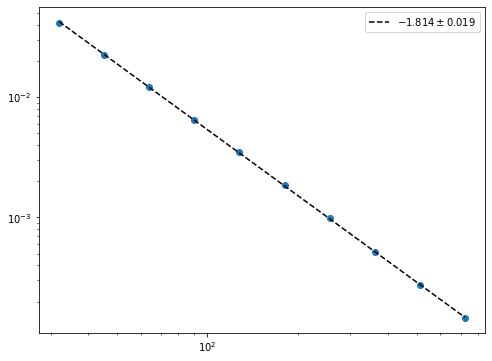

In [62]:
mean_deg = df.mean()

X = np.sqrt(mean_deg.index)
Y = 6 - 2 * mean_deg.values / mean_deg.index
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y_pred[-1] / X[-1]**slope

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, Y, 'o')
ax.plot(X, powerlaw(X, slope, c), '--', color='k', 
        label=r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.show()

In [63]:
seeds = range(1)
dir_name = NETWORKS_DIR / net_type

sizes = [
    #1024,    2048,    4096,    8192,    
    #16384
    #32768, 65536
    #131072, 262144
    #524288
    1048576
]

for size in sizes:
    print(size)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    base_net_dir = dir_name / base_net_name / base_net_name_size
    for seed in seeds:    
        network = f'{base_net_name_size}_{seed:05d}'
        net_dir = base_net_dir / network
        g = read_data_file(str(net_dir), network, reader='igraph')
        ecount = g.ecount()
        ecounts[size].append(ecount)

1048576


In [73]:
deg_seq = np.array(g.degree())

In [74]:
neighbors = [g.neighbors(v) for v in range(size)]

In [110]:
data = []
for v in range(size):
    if v%100000 == 0:
        print(v)
    masked = deg_seq[neighbors[v]]
    data.append([deg_seq[v], masked.mean(), masked.std(), masked.max()])

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [111]:
df = pd.DataFrame(data, columns=['deg', 'nn_mean', 'nn_std', 'nn_max'])
df['cv'] = df.nn_std / df.nn_mean
df.head()

,deg,nn_mean,nn_std,nn_max,cv
0,6,6.500000,1.118034,7,0.172005
1,7,6.571429,1.399708,8,0.212999
2,6,6.166667,0.687184,7,0.111435
3,6,6.833333,0.897527,8,0.131345
4,10,5.800000,1.469694,8,0.253395


<AxesSubplot:xlabel='deg'>

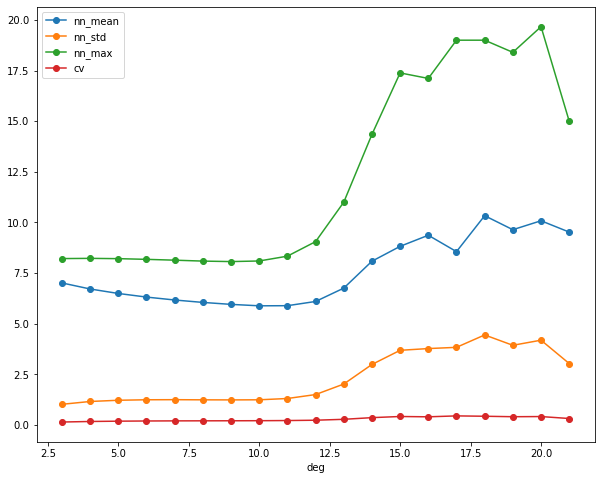

In [113]:
fig, ax = plt.subplots(figsize=(10,8))
#ax.set_xlim(2.9, 12.1)
#ax.set_ylim(5.5, 8.5)
df.groupby(by='deg').mean().plot(marker='o', ax=ax)

<AxesSubplot:xlabel='deg'>

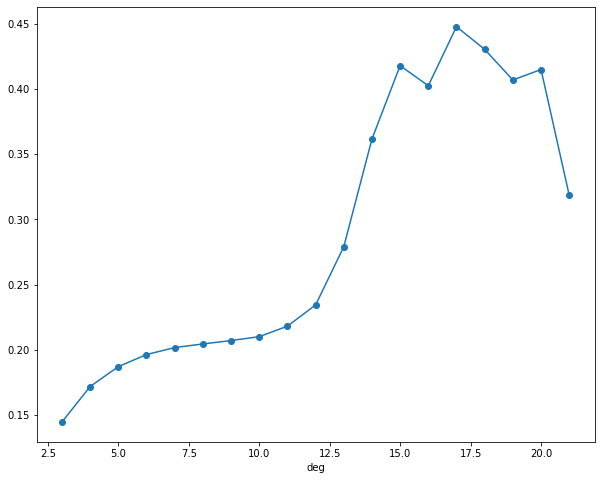

In [114]:
fig, ax = plt.subplots(figsize=(10,8))
#ax.set_xlim(2.9, 12.1)
#ax.set_ylim(5.5, 8.5)
df.groupby(by='deg').mean().cv.plot(marker='o', ax=ax)

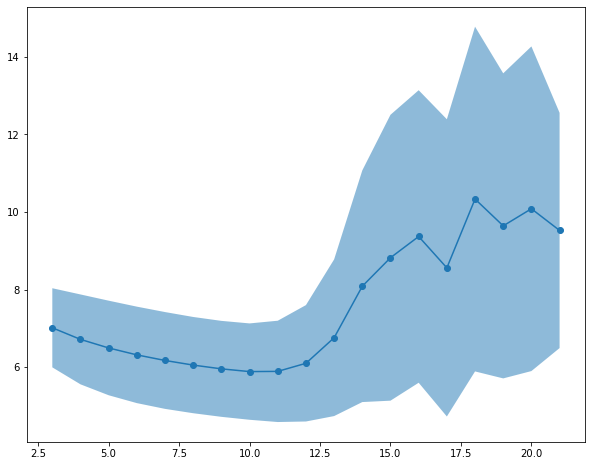

In [119]:
fig, ax = plt.subplots(figsize=(10,8))
#ax.set_xlim(2.9, 12.1)
#ax.set_ylim(5.5, 8.5)
grouped_df = df.groupby(by='deg').mean()
ax.plot(grouped_df.index, grouped_df.nn_mean, 'o-')
ax.fill_between(grouped_df.index, grouped_df.nn_mean-grouped_df.nn_std, grouped_df.nn_mean+grouped_df.nn_std, alpha=0.5)

<AxesSubplot:xlabel='deg'>

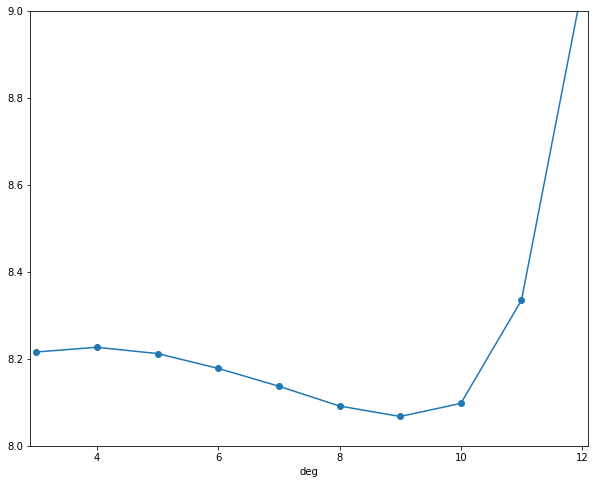

In [108]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(2.9, 12.1)
ax.set_ylim(8,9)
df.groupby(by='deg').mean().nn_max.plot(marker='o', ax=ax)

In [95]:
df.deg.max()

21

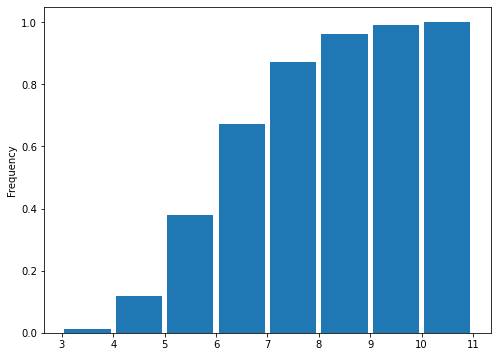

In [99]:
#bins = np.arange(3, df.deg.max()+1)
bins = np.arange(3, 12)
fig, ax = plt.subplots(figsize=(8,6))
df.deg.plot(kind='hist', bins=bins, 
            #log=True, 
            rwidth=0.9, ax=ax, cumulative=True, density=True)
ax.set_xticks(bins)
plt.show()

In [109]:
data

[[6, 6.5, 7],
 [7, 6.571428571428571, 8],
 [6, 6.166666666666667, 7],
 [6, 6.833333333333333, 8],
 [10, 5.8, 8],
 [5, 6.8, 8],
 [5, 5.8, 7],
 [7, 6.285714285714286, 8],
 [5, 6.8, 8],
 [5, 6.8, 9],
 [6, 6.5, 8],
 [8, 6.125, 11],
 [9, 5.666666666666667, 8],
 [5, 6.8, 7],
 [10, 6.0, 8],
 [7, 5.714285714285714, 8],
 [4, 7.0, 7],
 [6, 6.833333333333333, 10],
 [6, 6.333333333333333, 8],
 [6, 6.166666666666667, 7],
 [4, 6.5, 7],
 [7, 7.0, 12],
 [6, 7.0, 9],
 [8, 5.875, 8],
 [6, 6.166666666666667, 8],
 [7, 6.428571428571429, 9],
 [8, 6.125, 8],
 [5, 7.0, 9],
 [4, 6.5, 9],
 [8, 5.375, 7],
 [4, 6.0, 7],
 [5, 7.0, 9],
 [5, 6.6, 9],
 [9, 6.111111111111111, 8],
 [7, 6.0, 7],
 [5, 6.4, 8],
 [8, 5.5, 8],
 [6, 6.166666666666667, 7],
 [5, 6.0, 7],
 [6, 6.0, 7],
 [6, 6.833333333333333, 10],
 [5, 6.2, 8],
 [6, 6.666666666666667, 10],
 [7, 6.428571428571429, 9],
 [7, 6.428571428571429, 8],
 [7, 6.428571428571429, 8],
 [7, 6.0, 6],
 [10, 6.2, 8],
 [7, 6.428571428571429, 8],
 [4, 6.5, 9],
 [8, 6.375, 8],
 [